In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Load data
flight_df = pd.read_csv(
    './data/Flight_Level_Data.csv',
    parse_dates=['scheduled_departure_datetime_local','actual_departure_datetime_local']
)
pnr_df = pd.read_csv('./data/PNR_Flight_Level_Data.csv', parse_dates=['pnr_creation_date'])
remarks_df = pd.read_csv('./data/PNR_Remark_Level_Data.csv')
bag_df = pd.read_csv('./data/Bag_Level_Data.csv', parse_dates=['bag_tag_issue_date'])
flight_df.head()
# print("Flight DF Sample:\n", flight_df.head())
# print("PNR DF Sample:\n", pnr_df.head())
# print("Remarks DF Sample:\n", remarks_df.head())
# print("Bag DF Sample:\n", bag_df.head())


,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,fleet_type,carrier,scheduled_ground_time_minutes,actual_ground_time_minutes,minimum_turn_minutes
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04 17:57:00+00:00,2025-08-04T21:04:00Z,2025-08-04 18:04:00+00:00,2025-08-04T20:52:00Z,76,ERJ-175,Express,42,34,34
1,UA,920,2025-08-03,ORD,LHR,2025-08-03 18:05:00+00:00,2025-08-04T08:20:00Z,2025-08-03 18:27:00+00:00,2025-08-04T08:06:00Z,167,B767-300,Mainline,235,229,145
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10 18:20:00+00:00,2025-08-10T21:35:00Z,2025-08-10 20:11:00+00:00,2025-08-10T23:26:00Z,166,B737-800,Mainline,76,69,51
3,OO,5790,2025-08-06,ORD,CRW,2025-08-06 18:20:00+00:00,2025-08-06T21:04:00Z,2025-08-06 20:05:00+00:00,2025-08-06T22:42:00Z,50,CRJ-200,Express,223,38,29
4,UA,1398,2025-08-05,ORD,ATL,2025-08-05 18:20:00+00:00,2025-08-05T21:29:00Z,2025-08-05 18:16:00+00:00,2025-08-05T21:49:00Z,166,B737-800,Mainline,75,72,51


In [3]:
pnr_df.head()

KeyboardInterrupt: 

In [36]:
remarks_df.head()

,record_locator,pnr_creation_date,flight_number,special_service_request
0,PNR_153489,2025-07-04,308,Airport Wheelchair
1,PNR_153489,2025-07-04,2182,Airport Wheelchair
2,PNR_153508,2025-07-10,2649,Airport Wheelchair
3,PNR_153508,2025-07-10,2100,Airport Wheelchair
4,PNR_153521,2025-03-01,970,Unaccompanied Minor


In [ ]:
bag_df.head()

In [ ]:

# STEP 2: Standardize airport codes and bag_group
flight_df['scheduled_arrival_station_code'] = flight_df['scheduled_arrival_station_code'].str.upper().str.strip()
flight_df['scheduled_departure_station_code'] = flight_df['scheduled_departure_station_code'].str.upper().str.strip()
bag_df['bag_group'] = bag_df.get('bag_group', bag_df.get('bag_type'))
# print("\nStandardized airport codes and bag_group")

# STEP 3: Compute baggage metrics
bag_counts = bag_df.groupby(['flight_number','scheduled_departure_date_local','bag_group']).size().unstack(fill_value=0)
bag_counts['Checked'] = bag_counts.get('Checked', 0)
bag_counts['Transfer'] = bag_counts.get('Transfer', 0)
bag_counts['transfer_to_checked_ratio'] = bag_counts['Transfer'] / bag_counts['Checked'].replace(0,1)
bag_counts.reset_index(inplace=True)
# print("\nBaggage Metrics Sample:\n", bag_counts.head())
bag_counts.head()


In [40]:

# Merge baggage metrics into flight_df
flight_df = flight_df.merge(bag_counts[['flight_number','scheduled_departure_date_local','transfer_to_checked_ratio']],
                            on=['flight_number','scheduled_departure_date_local'], how='left')
flight_df['transfer_to_checked_ratio'] = flight_df['transfer_to_checked_ratio'].fillna(0)
# print("\nMerged Transfer to Checked Ratio into Flight DF:\n", flight_df[['flight_number','transfer_to_checked_ratio']].head())
flight_df[['flight_number','transfer_to_checked_ratio']].head()


,flight_number,transfer_to_checked_ratio
0,4792,20.0
1,920,37.0
2,1776,38.0
3,5790,40.0
4,1398,51.0


In [41]:

# STEP 4: Compute passengers per flight
passengers_per_flight = pnr_df.groupby(['flight_number','scheduled_departure_date_local'])['total_pax'].sum().reset_index()
passengers_per_flight.rename(columns={'total_pax':'total_passengers'}, inplace=True)
flight_df = flight_df.merge(passengers_per_flight, on=['flight_number','scheduled_departure_date_local'], how='left')
flight_df['total_passengers'] = flight_df['total_passengers'].fillna(0)
flight_df['load_factor'] = flight_df['total_passengers'] / flight_df['total_seats'].replace(0,1)
# print("\nPassengers per flight and Load Factor:\n", flight_df[['flight_number','total_passengers','load_factor']].head())
flight_df[['flight_number','total_passengers','load_factor']].head()

,flight_number,total_passengers,load_factor
0,4792,65,0.855263
1,920,171,1.023952
2,1776,180,1.084337
3,5790,55,1.100000
4,1398,136,0.819277


In [42]:

# STEP 5: Compute SSR per passenger
ssr_per_flight = remarks_df.groupby(['flight_number','pnr_creation_date']).size().reset_index(name='ssr_count')
ssr_per_flight = ssr_per_flight.groupby('flight_number')['ssr_count'].sum().reset_index()
flight_df = flight_df.merge(ssr_per_flight, on='flight_number', how='left')
flight_df['ssr_count'] = flight_df['ssr_count'].fillna(0)
flight_df['ssr_per_pax'] = flight_df['ssr_count'] / flight_df['total_passengers'].replace(0,1)
# print("\nSSR per passenger sample:\n", flight_df[['flight_number','ssr_count','ssr_per_pax']].head())
flight_df[['flight_number','ssr_count','ssr_per_pax']].head()

,flight_number,ssr_count,ssr_per_pax
0,4792,41,0.630769
1,920,60,0.350877
2,1776,41,0.227778
3,5790,30,0.545455
4,1398,96,0.705882


In [43]:

# STEP 6: Ground time pressure
flight_df['ground_time_pressure'] = flight_df['scheduled_ground_time_minutes'] - flight_df['actual_ground_time_minutes']
flight_df['ground_time_pressure'] = flight_df['ground_time_pressure'].fillna(0)
# print("\nGround Time Pressure sample:\n", flight_df[['flight_number','ground_time_pressure']].head())
flight_df[['flight_number','ground_time_pressure']].head()

,flight_number,ground_time_pressure
0,4792,8
1,920,6
2,1776,7
3,5790,185
4,1398,3


In [44]:

# STEP 7: Aggregate difficulty metrics by destination
analysis_df = flight_df[['scheduled_arrival_station_code','load_factor','ssr_per_pax','ground_time_pressure','total_passengers']]
difficulty_metrics = analysis_df.groupby('scheduled_arrival_station_code').agg({
    'load_factor':'mean',
    'ssr_per_pax':'mean',
    'ground_time_pressure':'mean',
    'total_passengers':'sum'
}).reset_index()
# print("\nAggregated difficulty metrics by destination:\n", difficulty_metrics.head())
difficulty_metrics.head()

,scheduled_arrival_station_code,load_factor,ssr_per_pax,ground_time_pressure,total_passengers
0,ABE,0.950640,0.419483,13.758621,1415
1,ABQ,0.995139,0.469857,-4.928571,3667
2,ACK,1.454323,0.018814,12.750000,435
3,ALB,0.991692,0.416359,-14.840909,5780
4,AMS,1.012803,0.398206,9.000000,4209


In [45]:

# STEP 8: Compute normalized scores for driver identification
for col in ['load_factor','ssr_per_pax','ground_time_pressure']:
    difficulty_metrics[col+'_score'] = difficulty_metrics[col].rank(pct=True)

difficulty_metrics['difficulty_score'] = difficulty_metrics[['load_factor_score','ssr_per_pax_score','ground_time_pressure_score']].sum(axis=1)

# Identify main driver for each destination
def main_driver(row):
    driver_scores = {
        'Load Factor': row['load_factor_score'],
        'SSR per Pax': row['ssr_per_pax_score'],
        'Ground Time Pressure': row['ground_time_pressure_score']
    }
    return max(driver_scores, key=driver_scores.get)

difficulty_metrics['main_driver'] = difficulty_metrics.apply(main_driver, axis=1)

# STEP 9: Sort and display
difficulty_metrics = difficulty_metrics.sort_values(by='difficulty_score', ascending=False)
top_dest = difficulty_metrics.head(15)
print("\nTop 15 Difficult Destinations with Main Drivers:")
# print(top_dest[['scheduled_arrival_station_code','difficulty_score','main_driver']])
top_dest[['scheduled_arrival_station_code','difficulty_score','main_driver']]


Top 15 Difficult Destinations with Main Drivers:


,scheduled_arrival_station_code,difficulty_score,main_driver
60,FAT,2.617021,Ground Time Pressure
135,PNS,2.473404,Ground Time Pressure
147,RSW,2.345745,SSR per Pax
40,CRW,2.260638,Ground Time Pressure
118,MTY,2.260638,SSR per Pax
133,PLN,2.228723,SSR per Pax
77,GUA,2.212766,Load Factor
64,FNT,2.202128,SSR per Pax
142,RHI,2.170213,Ground Time Pressure
63,FLL,2.159574,Ground Time Pressure


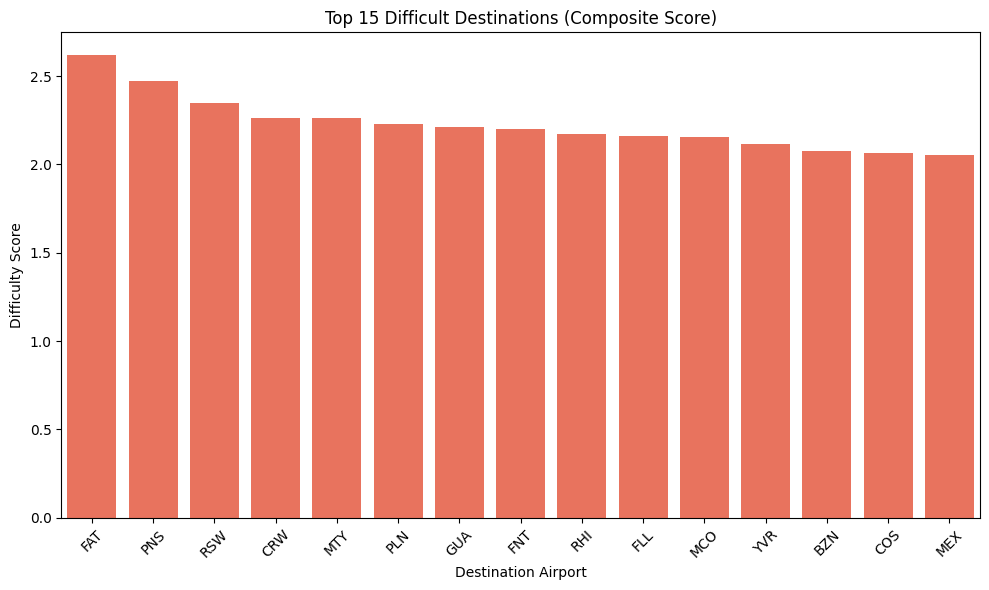

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

top_dest = difficulty_metrics.head(15)

# 1. Composite Difficulty Score
plt.figure(figsize=(10,6))
sns.barplot(x='scheduled_arrival_station_code', y='difficulty_score', data=top_dest, color='tomato')
plt.title("Top 15 Difficult Destinations (Composite Score)")
plt.xlabel("Destination Airport")
plt.ylabel("Difficulty Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Counts of Main Drivers in Top 15 Destinations:
 main_driver
Ground Time Pressure    7
SSR per Pax             5
Load Factor             3
Name: count, dtype: int64


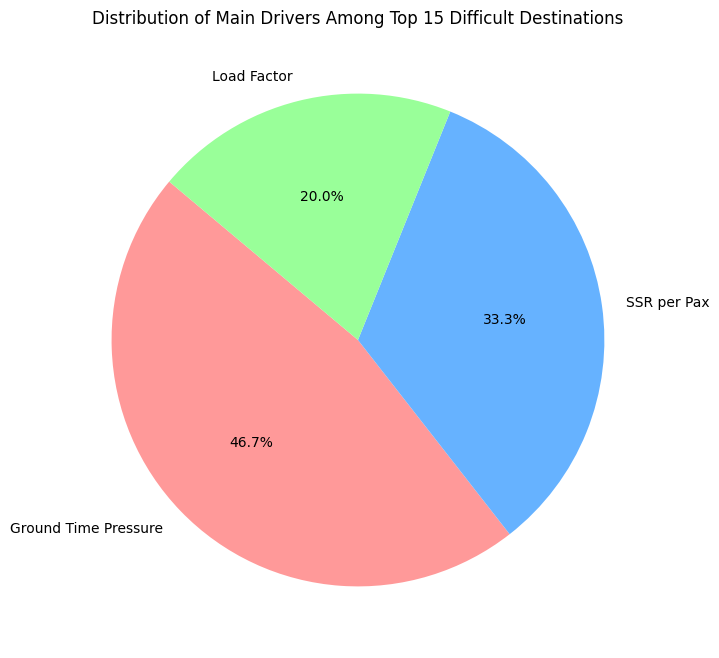

In [46]:
# STEP 11: Pie Chart for Main Drivers
driver_counts = top_dest['main_driver'].value_counts()
print("\nCounts of Main Drivers in Top 15 Destinations:\n", driver_counts)

plt.figure(figsize=(8,8))
plt.pie(driver_counts, labels=driver_counts.index, autopct='%1.1f%%', startangle=140, colors=['#FF9999','#66B2FF','#99FF99'])
plt.title("Distribution of Main Drivers Among Top 15 Difficult Destinations")
plt.show()


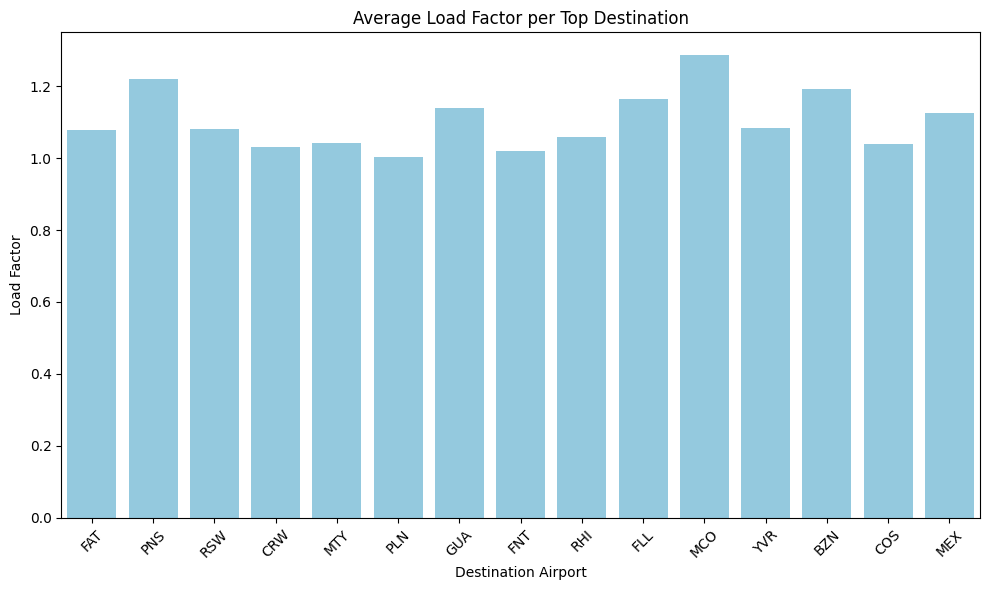

In [30]:

# 2. Load Factor
plt.figure(figsize=(10,6))
sns.barplot(x='scheduled_arrival_station_code', y='load_factor', data=top_dest, color='skyblue')
plt.title("Average Load Factor per Top Destination")
plt.xlabel("Destination Airport")
plt.ylabel("Load Factor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


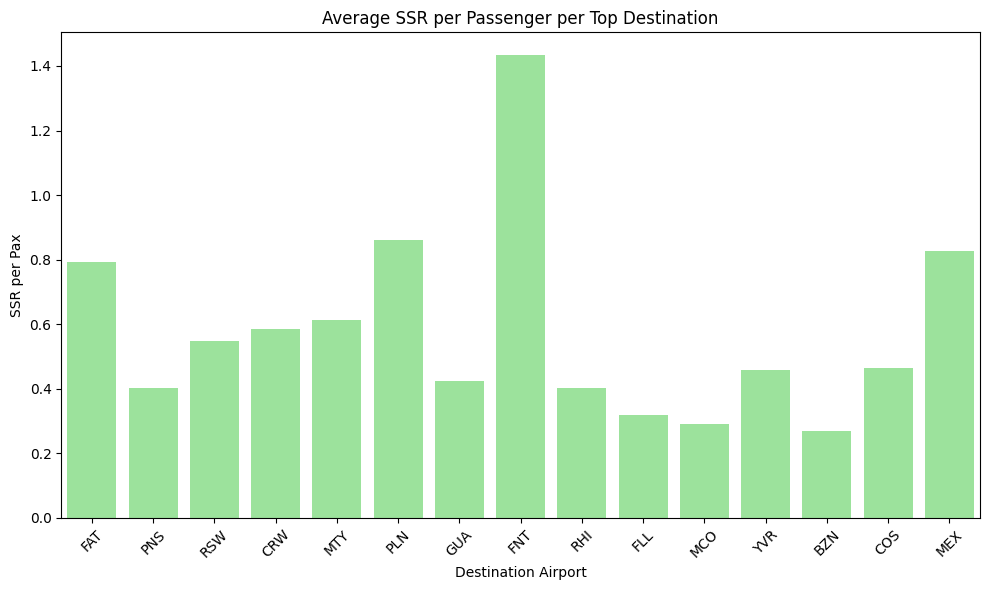

In [31]:

# 3. SSR per Passenger
plt.figure(figsize=(10,6))
sns.barplot(x='scheduled_arrival_station_code', y='ssr_per_pax', data=top_dest, color='lightgreen')
plt.title("Average SSR per Passenger per Top Destination")
plt.xlabel("Destination Airport")
plt.ylabel("SSR per Pax")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


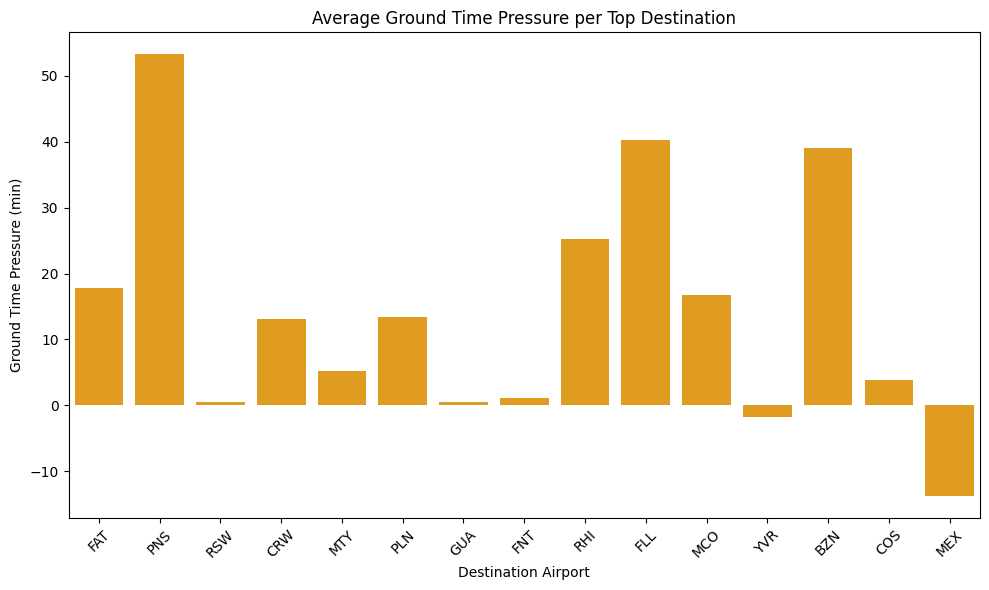

In [32]:

# 4. Ground Time Pressure
plt.figure(figsize=(10,6))
sns.barplot(x='scheduled_arrival_station_code', y='ground_time_pressure', data=top_dest, color='orange')
plt.title("Average Ground Time Pressure per Top Destination")
plt.xlabel("Destination Airport")
plt.ylabel("Ground Time Pressure (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
